# Analyzing the output of a polychrom simulation

Running example.py generates a few different output files, one with the starting conformation, one with the intial arguments, one with the appliced forces, one with the forcekit, and finally the blocks. Here, we ran 10 blocks, each of 100 timesteps each, and set the max data length to 5.

In [45]:
import sys
sys.path.insert(0,'../..')

In [48]:
cd plots

[Errno 2] No such file or directory: 'plots'
/home/dkannan/git-remotes/polychrom/notebooks


In [2]:
from numba import jit

In [3]:
#Here are the import statements sameer used in his notebook to analyze a simulation
import os
from pathlib import Path
import importlib as imp
from collections import defaultdict
import h5py
import json
from copy import deepcopy
import multiprocessing as mp

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import numpy.ma as ma
import pandas as pd
import scipy
import scipy.stats
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d, interp2d

import polychrom
from polychrom import polymer_analyses, contactmaps, polymerutils
from polychrom.hdf5_format import list_URIs, load_URI, load_hdf5_file

#import nglutils as ngu
#import nglview as nv

## Reading data

list_URIs will list all of the files starting with `block` with one URI (universal resource identifier aka path) per conformation

In [6]:
trajs = list_URIs('trajectory')
print(trajs)

['trajectory/blocks_0-4.h5::0', 'trajectory/blocks_0-4.h5::1', 'trajectory/blocks_0-4.h5::2', 'trajectory/blocks_0-4.h5::3', 'trajectory/blocks_0-4.h5::4', 'trajectory/blocks_5-9.h5::5', 'trajectory/blocks_5-9.h5::6', 'trajectory/blocks_5-9.h5::7', 'trajectory/blocks_5-9.h5::8', 'trajectory/blocks_5-9.h5::9']


In [4]:
#TODO: figure out how to extract initial parameters from other h5 files

In [7]:
data = load_URI(trajs[0])

In [8]:
data

{'pos': array([[-0.47, -1.51, -0.37],
        [-0.45, -1.95,  0.55],
        [ 0.45, -2.32,  0.71],
        ...,
        [ 2.05, -1.76,  0.76],
        [ 1.21, -1.56,  0.26],
        [ 0.5 , -1.88, -0.22]], dtype=float32),
 'block': 0,
 'kineticEnergy': 1.8880411331282307,
 'potentialEnergy': 2.5845410077802025,
 'time': 6.356380507349968}

In [9]:
ls trajectory

applied_forces_0.h5  blocks_5-9.h5                 initArgs_0.h5
blocks_0-4.h5        forcekit_polymer_chains_0.h5  starting_conformation_0.h5


In [15]:
with h5py.File("trajectory/initArgs_0.h5", 'r') as f:
    N = f.attrs['N']
N

10000

In [1]:
ls simulations/test_integrator

applied_forces_0.h5  blocks_400-499.h5  blocks_900-999.h5
blocks_0-99.h5       blocks_500-599.h5  forcekit_polymer_chains_0.h5
blocks_100-199.h5    blocks_600-699.h5  initArgs_0.h5
blocks_200-299.h5    blocks_700-799.h5  starting_conformation_0.h5
blocks_300-399.h5    blocks_800-899.h5


In [6]:
ls /home/dkannan/simulations/

test_integrator/


## Computing P(s) scaling as a function of simulation time

In [65]:
from cooltools.lib import numutils
from pathlib import Path
from functools import partial

from matplotlib.colors import LogNorm, Normalize
import seaborn as sns

basepath ='/net/levsha/share/deepti/simulations/Deq1/varLangevin_N10000/runs200000_100/run0'

In [56]:
def draw_power_law_triangle(alpha, x0, width, orientation, base=10,
                            hypotenuse_only=False, **kwargs):
    """Draw a triangle showing the best-fit power-law on a log-log scale.

    Parameters
    ----------
    alpha : float
        the power-law slope being demonstrated
    x0 : (2,) array_like
        the "left tip" of the power law triangle, where the hypotenuse starts
        (in log units, to be consistent with draw_triangle)
    width : float
        horizontal size in number of major log ticks (default base-10)
    orientation : string
        'up' or 'down', control which way the triangle's right angle "points"
    base : float
        scale "width" for non-base 10

    Returns
    -------
    corner : (2,) np.array
        coordinates of the right-angled corner of the triangle
    """
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = 'k'
    x0, y0 = [base**x for x in x0]
    x1 = x0*base**width
    y1 = y0*(x1/x0)**alpha
    plt.plot([x0, x1], [y0, y1], 'k')
    if (alpha >= 0 and orientation == 'up') \
    or (alpha < 0 and orientation == 'down'):
        if hypotenuse_only:
            plt.plot([x0, x1], [y0, y1], color=color, **kwargs)
        else:
            plt.plot([x0, x1], [y1, y1], color=color, **kwargs)
            plt.plot([x0, x0], [y0, y1], color=color, **kwargs)
        # plt.plot lines have nice rounded caps
        # plt.hlines(y1, x0, x1, **kwargs)
        # plt.vlines(x0, y0, y1, **kwargs)
        corner = [x0, y1]
    elif (alpha >= 0 and orientation == 'down') \
    or (alpha < 0 and orientation == 'up'):
        if hypotenuse_only:
            plt.plot([x0, x1], [y0, y1], color=color, **kwargs)
        else:
            plt.plot([x0, x1], [y0, y0], color=color, **kwargs)
            plt.plot([x1, x1], [y0, y1], color=color, **kwargs)
        # plt.hlines(y0, x0, x1, **kwargs)
        # plt.vlines(x1, y0, y1, **kwargs)
        corner = [x1, y0]
    else:
        raise ValueError(r"Need $\alpha\in\mathbb{R} and orientation\in{'up', 'down'}")
    return corner

In [66]:
with h5py.File(Path(basepath)/"initArgs_0.h5", 'r') as f:
    N = f.attrs['N']
chains = np.arange(0, N+1, N)

T_steps = 200000
integrations_per_save = 100
T_blocks = T_steps

col_rate = 0.03
density = 0.224

In [67]:
bin_edges = numutils._logbins_numba(1, N, ratio=1.25, prepend_zero=True)
bin_edges

array([    0,     1,     2,     3,     4,     5,     6,     8,    10,
          13,    16,    20,    25,    32,    40,    50,    63,    79,
         100,   126,   158,   200,   251,   316,   398,   501,   631,
         794,  1000,  1259,  1585,  1995,  2512,  3162,  3981,  5012,
        6310,  7943, 10000])

In [68]:
start = int(0.005*T_blocks)
end = T_blocks
block_ratio = 1.25
blocks = numutils._logbins_numba(start, end, ratio=block_ratio, prepend_zero=False)
cutoff_rad = 1.0
blocks

array([  1000,   1272,   1619,   2060,   2620,   3334,   4242,   5397,
         6867,   8736,  11115,  14142,  17993,  22893,  29127,  37058,
        47149,  59989,  76324,  97108, 123551, 157195, 200000])

In [69]:
def process(uri, blocks, bin_edges, chains, cutoff=1.1):
    idx = int(uri.split('::')[-1])
    data = load_URI(uri)['pos']

    ser = {}
    chunk = np.searchsorted(blocks, idx, side='right')
    ser['chunk'] = [chunk]

    bins = None
    contacts = None
    for st, end in zip(chains[0:-1],chains[1:]):
        conf = data[st:end,:]
        x,y = polymer_analyses.contact_scaling(conf, bins0=bin_edges, cutoff=cutoff)
        if bins is None:
            bins = x
        if contacts is None:
            contacts = y
        else:
            contact = contacts + y

    ser['Ps'] = [(bins, contacts)]
    return pd.DataFrame(ser)


In [70]:
uris = list_URIs(f'{basepath}')
df = process(uris[-1], blocks, bin_edges, chains, cutoff=1.0)
np.array(df['Ps'])

array([([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.48074069840786, 8.48528137423857, 10.954451150103322, 13.96424004376894, 17.435595774162696, 21.908902300206645, 27.83882181415011, 35.32704346531139, 44.27188724235731, 55.67764362830022, 70.09992867328754, 88.43641783790206, 111.80339887498948, 140.6484980367725, 177.31892172015935, 223.60679774997897, 281.1849924871525, 354.1920383069049, 446.09416046390925, 561.8095762800773, 707.3775512412025, 890.6211315705461, 1121.6059914247962, 1412.181291477833, 1777.776701388563, 2238.178947269409, 2817.8772152100596, 3547.5005285411867, 4466.4069451853575, 5623.229321306397, 7079.1256522257045, 8911.905351831336], array([0.00000000e+00, 4.38943894e-01, 4.62092418e-02, 1.10033010e-02,
              5.20208083e-03, 3.20160080e-03, 1.35087807e-03, 6.50552970e-04,
              5.00550606e-04, 4.33940851e-04, 3.25569747e-04, 1.20264582e-04,
              8.59549596e-05, 1.12900798e-04, 6.02681935e-05, 3.09425088e-05,
              1.88831260e-05, 2.40233

In [ ]:
sim = 'varLangevin_N10000_Deq1'
uris = list_URIs(f'{basepath}')
savepath = f'{basepath}/results'
Path(savepath).mkdir(exist_ok=True)
cutoff_rad = 1.0
savename = f'{sim}__logtime{str(start).zfill(5)}-{str(end).zfill(5)}-{block_ratio:.2f}__cutoff{cutoff_rad:.1f}.npy'


f = partial(process, blocks=blocks, bin_edges=bin_edges, chains=chains, cutoff=cutoff_rad)
with mp.Pool(20) as p:
    results = p.imap_unordered(f, uris, chunksize=5)
    df = polymer_analyses.streaming_ndarray_agg(results, 
                                                chunksize=5000,
                                                ndarray_cols=['Ps'], 
                                                aggregate_cols=['chunk'], 
                                                add_count_col=True, divide_by_count=True
                                                )

result = []
for _, row in df.iterrows():
    arr = row['Ps']
    arr[1,0] = 1
    result.append(arr)

result = np.dstack(result)

np.save(f'{savepath}/{savename}', result)
print(savename)

## Plot P(s) scaling

(2, 27, 23)
(23,)
-2.499400930316002


/tmp/ipykernel_31861/1691336888.py:26: RuntimeWarning: divide by zero encountered in log10
  m = scipy.stats.linregress(np.log10(x)[(x > 2.0) & (x <= 10.0)],


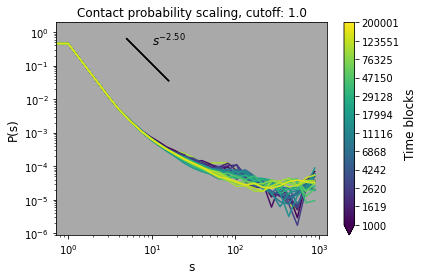

In [64]:
loadpath = savepath
cmap = plt.get_cmap('viridis')
crange = np.log10(blocks)
norm = mpl.colors.Normalize(vmin=crange.min(),vmax=crange.max())

fig, ax = plt.subplots()

filename = f'{sim}__logtime{str(start).zfill(5)}-{str(end).zfill(5)}-{block_ratio:.2f}__cutoff{cutoff_rad:.1f}.npy'

ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_aspect('equal')
ax.set_facecolor('darkgray')
#ax.set_xlim([10**3,5*10**7])
#ax.set_ylim([5*10**-3, 10**0])

arr = np.load(f'{loadpath}/{filename}')
print(arr.shape)
print(blocks.shape)
for k in range(arr.shape[-1]):
    Bst = 0 if not k else blocks[k-1]
    Bend = blocks[k-1]
    x = arr[0,:,k]
    y = arr[1,:,k]
    if k == (len(blocks) - 1):
        m = scipy.stats.linregress(np.log10(x)[(x > 2.0) & (x <= 10.0)], 
                                   np.log10(y)[(x > 2.0) & (x <= 10.0)])[0]
        print(m)
    cval = np.log10((Bend+Bst)/2)
    ax.plot(x, y, color=cmap(norm(cval)))

corner = draw_power_law_triangle(m, [0.7, -0.2], 0.5, 'up', base=10, hypotenuse_only=True)
plt.text(10.0, 0.4, f'$s^{{{m:.2f}}}$', fontsize=12)
plt.title(f'Contact probability scaling, cutoff: {cutoff_rad:.1f}')
#cax = fig.add_subplot(gs[:,-1])
slicing = slice(0,len(crange),2)
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), extend='min', ticks=crange[slicing])
cbar.ax.set_yticklabels([x for x in np.ceil((10**crange[slicing])).astype(int)])
cbar.ax.set_ylabel('Time blocks', fontsize=12)
plt.xlabel('s', fontsize=12)
plt.ylabel('P(s)', fontsize=12)
fig.tight_layout()
#plt.savefig('plots/contact_scaling_{sim}_{str(start).zfill(5)}-{str(end).zfill(5)}-{block_ratio:.2f}__cutoff{cutoff_rad:.1f}.pdf')

# Plot contact map

In [20]:
from matplotlib.gridspec import GridSpec

In [21]:
def extract_conformations(basepath):
    basepath = Path(basepath)
    conformations = []
    run_numbers = []
    for p in basepath.glob('*'):
        dirname = int(str(p.name)[3:])
        run_numbers.append(dirname)
        try: 
            uris = list_URIs(p)
            #conformations.append(uris[-1])
            conformations = conformations + uris[1000::1000]
        except:
            continue
    print(f'Number of simulations in directory: {len(run_numbers)}')
    print(f'Number of conformations extracted: {len(conformations)}')
    return conformations

In [24]:
#find all conformations in basepath director
#2500 simulations each with 10000 blocks of 100 time steps (10^5 time steps total)
basepath = Path('/net/levsha/share/deepti/simulations/stickyAB')
conformations = []
run_numbers = []
for p in basepath.glob('*'):
    #dirname = int(str(p.name)[3:])
    #run_numbers.append(dirname)
    try: 
        uris = list_URIs(p)
        print(len(uris))
        #conformations.append(uris[-1])
        conformations = conformations + uris[1000:]
    except:
        continue
len(conformations)

2000


1000

In [7]:
len(run_numbers)

2567

In [68]:
basepath = Path('/home/dkannan/simulations/step_7x/long_runs')
conformations = []
run_numbers = []
for p in basepath.glob('*'):
    numdirs += 1
    dirname = int(str(p.name)[3:])
    run_numbers.append(dirname)
    try: 
        uris = list_URIs(p)
        #conformations.append(uris[-1])
        conformations = conformations + uris[50000::5]
    except:
        continue
len(conformations)

30000

In [47]:
run_numbers = np.sort(run_numbers)
run_numbers[0:20]

array([ 0,  1,  2,  3,  4,  8,  9, 10, 11, 16, 17, 18, 19, 24, 25, 26, 27,
       32, 33, 34])

In [50]:
def plot_contact_maps(conformations, run_numbers, basepath, simstring):
    cutoff_rads = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
    num_rows = 2
    num_cols = 3
    fig = plt.figure(figsize=(3*num_cols, 2 + 2*num_rows))

    fig.suptitle(f'Ensemble average of {len(conformations)} snapshots from {len(run_numbers)} simulations with $10^6$ timesteps', 
                 fontsize=14, fontweight='bold')
    gs = GridSpec(nrows=num_rows, ncols=num_cols, 
                  width_ratios=[100]*num_cols)

    for i in range(len(cutoff_rads)):
        x = i // num_cols
        y = i % num_cols
        ax = fig.add_subplot(gs[x, y])
        ax.set_xticks([])
        ax.set_yticks([])
        mat = contactmaps.monomerResolutionContactMap(filenames=conformations, cutoff=cutoff_rads[i])
        mat2 = mat / len(conformations)
        #save cutoff radius = 2.0 contact map for andriy to invert
        if i == 2:
            np.save(Path(basepath)/f'contact_map_{simstring}_cutoff2.0.npy', mat2)
        mat2[mat2 == 0] = mat2[mat2 > 0].min() / 2.0
        lognorm = LogNorm(vmin=mat2.min(), vmax=mat2.max())
        im = ax.imshow(mat2, norm=lognorm, cmap='YlOrRd')
        ax.set_title(r'$\bf{Cutoff:}$' + f' {cutoff_rads[i]}', fontsize=12)
        plt.colorbar(im, ax=ax)

    #hmap_cax = fig.add_subplot(gs[:,-1])
    #hmap_cax.yaxis.set_label_position("left")
    #hmap_cax.set_ylabel('log10 [ Contactmap ]', fontsize=12, fontweight='bold')
    #ax.set_xlabel(r'Bead $i$')
    #ax.set_ylabel(r'Bead $j$')
    fig.tight_layout()
    #plt.savefig(f'plots/{simstring}_n{len(conformations)}.pdf')

not really seeing compartments after 10^5 time steps

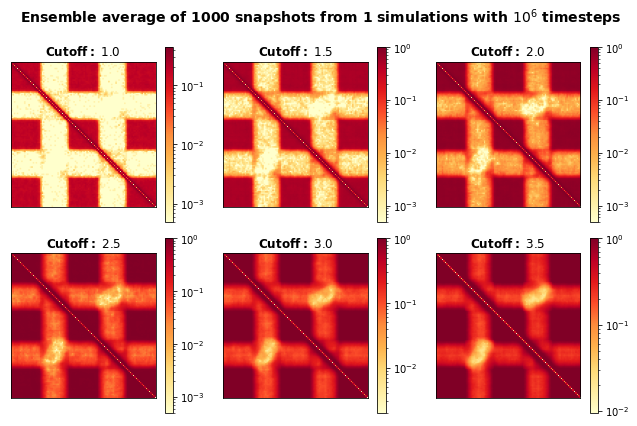

In [51]:
#analyze simulations
run_numbers = [1]
plot_contact_maps(conformations, run_numbers, basepath, 'stickyAB_test')

In [28]:
pwd

'/home/dkannan/git-remotes/polychrom/notebooks'

# Plot monomer MSDs

In [54]:
def compute_single_trajectory_msd(simdir, start=100000, every_other=10):
    simdir = Path(simdir)
    data = list_URIs(simdir)
    if start == 0:
        starting_pos = load_hdf5_file(simdir/"starting_conformation_0.h5")['pos']
    else:
        starting_pos = load_URI(data[start])['pos']
    dxs = []
    for conformation in data[start:(start + every_other)]:
        pos = load_URI(conformation)['pos']
        dx_squared = np.sum((pos - starting_pos)**2, axis=-1)
        dxs.append(dx_squared)
    for conformation in data[(start + every_other)::every_other]:
        pos = load_URI(conformation)['pos']
        dx_squared = np.sum((pos - starting_pos)**2, axis=-1)
        dxs.append(dx_squared)
    dxs = np.array(dxs)
    print(simdir)
    return dxs

In [55]:
def plot_MSD_ensemble_ave(basepath, activity_ratio=5.974, every_other=10, ncores=25):
    """ Plot the ensemble averaged MSD curves for active and inactive regions."""
    ids = np.load('/net/levsha/share/deepti/data/ABidentities_blobel2021_chr2_35Mb_60Mb.npy')
    N=len(ids)
    #0 is cold, 1 is hot
    D = np.ones(N)
    Ddiff = (activity_ratio - 1) / (activity_ratio + 1)
    D[ids==0] = 1.0 - Ddiff
    D[ids==1] = 1.0 + Ddiff
    basepath = Path(basepath)
    rundirs = [f for f in basepath.iterdir() if f.is_dir()]
    with mp.Pool(ncores) as p:
        msds = p.map(compute_single_trajectory_msd, rundirs)
    msds = np.array(msds) #shape: (#runs, #timesteps, #monomers)
    hot_msd_ave = np.mean(msds[:, :, D==D.max()], axis=(0, -1))
    cold_msd_ave = np.mean(msds[:, :, D==D.min()], axis=(0, -1))
    df = pd.DataFrame(columns=['Time', 'active_MSD', 'inactive_MSD'])
    df['Time'] = np.concatenate((np.arange(0, 10), np.arange(1, len(hot_msd_ave)) * every_other)) #in units of blocks of time steps
    df['active_MSD'] = hot_msd_ave
    df['inactive_MSD'] = cold_msd_ave
    df.to_csv(f'/net/levsha/share/deepti/data/ens_ave_active_inactive_msds_blobel2021_{activity_ratio}x.csv')

In [56]:
ids = np.load('/net/levsha/share/deepti/data/ABidentities_blobel2021_chr2_35Mb_60Mb.npy')
N=len(ids)
#0 is cold, 1 is hot
D = np.ones(N)
Ddiff = (5.974 - 1) / (5.974 + 1)
D[ids==0] = 1.0 - Ddiff
D[ids==1] = 1.0 + Ddiff

In [11]:
%%time
basepath = Path('/net/levsha/share/deepti/simulations/chr2_blobel_AB/comps_5.974x/runs200000_100')
#Xcold, Xhot = extract_hot_cold(basepath/'run0', D, every_other=10)
#print(Xcold.shape)

CPU times: user 59 µs, sys: 7 µs, total: 66 µs
Wall time: 73.4 µs


In [21]:
%%time
hot_bead_msd, cold_bead_msd = get_bead_msd(Xhot, Xcold)

CPU times: user 1.91 s, sys: 2.68 ms, total: 1.91 s
Wall time: 1.96 s


In [57]:
%%time
trajs = [basepath/'run1', basepath/'run2']
with mp.Pool(2) as p:
    msds = p.map(compute_single_trajectory_msd, trajs)
len(msds)

/net/levsha/share/deepti/simulations/chr2_blobel_AB/comps_5.974x/runs200000_100/run2
/net/levsha/share/deepti/simulations/chr2_blobel_AB/comps_5.974x/runs200000_100/run1
CPU times: user 108 ms, sys: 162 ms, total: 270 ms
Wall time: 2min 5s


2

In [66]:
msds = np.array(msds)
print(msds.shape)
hot_msd_ave = np.mean(msds[:, :, D==D.max()], axis=(0, -1))
print(hot_msd_ave.shape)
cold_msd_ave = np.mean(msds[:, :, D==D.min()], axis=(0, -1))
df = pd.DataFrame(columns=['Time', 'active_MSD', 'inactive_MSD'])
df['Time'] = np.concatenate((np.arange(0, 10), np.arange(1, 10000) * 10))
df['active_MSD'] = hot_msd_ave
df['inactive_MSD'] = cold_msd_ave
df
#df.to_csv(f'/net/levsha/share/deepti/data/ens_ave_active_inactive_msds_test.csv')

(2, 10009, 1000)
(10009,)


,Time,active_MSD,inactive_MSD
0,0,0.000000,0.000000
1,1,0.869762,0.212147
2,2,1.464126,0.369152
3,3,1.791127,0.495590
4,4,2.221309,0.610090
...,...,...,...
10004,99950,115.034180,81.308670
10005,99960,114.064934,81.896790
10006,99970,112.126137,81.106155
10007,99980,112.802773,81.547195


In [65]:
df = pd.read_csv(f'/net/levsha/share/deepti/data/ens_ave_active_inactive_msds_test.csv')
df

,Unnamed: 0,Time,active_MSD,inactive_MSD
0,0,0,0.000000,0.000000
1,1,10,3.253989,1.075954
2,2,20,4.992727,1.585103
3,3,30,5.921203,1.938504
4,4,40,6.863293,2.316350
...,...,...,...,...
9995,9995,99950,115.034180,81.308670
9996,9996,99960,114.064930,81.896790
9997,9997,99970,112.126140,81.106155
9998,9998,99980,112.802770,81.547195


<IPython.core.display.Javascript object>


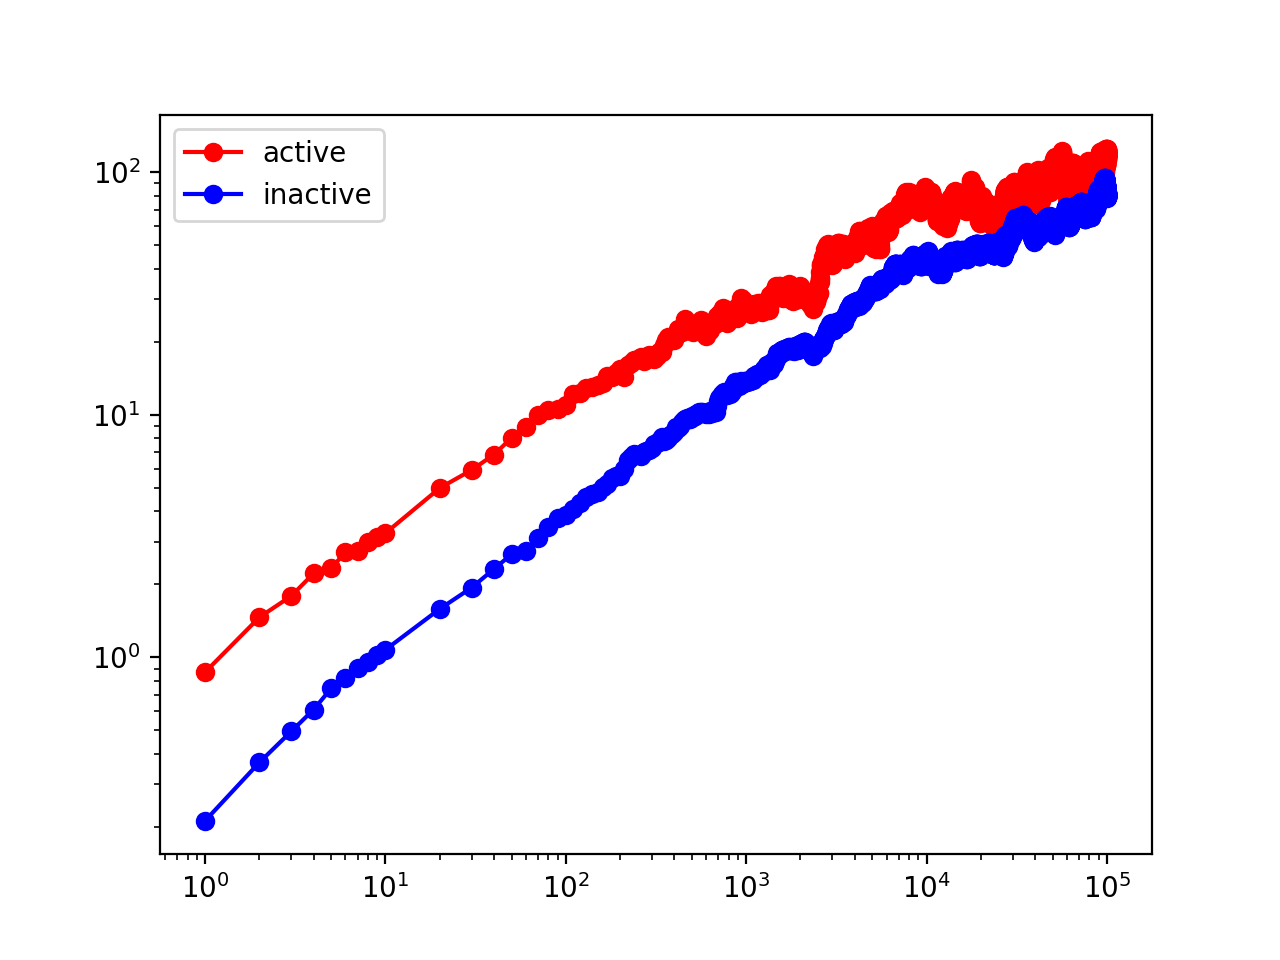

In [69]:
fig, ax = plt.subplots()
ax.loglog(df['Time'].values[1:], df['active_MSD'].values[1:], 'o-', color='red', label='active')
ax.plot(df['Time'].values[1:], df['inactive_MSD'].values[1:], 'o-', color='blue', label='inactive')
plt.legend()

In [18]:
df = pd.read_csv(f'/net/levsha/share/deepti/data/ens_ave_active_inactive_msds_blobel2021_10.0x.csv')
df[10:]

,Time,active_MSD,inactive_MSD
10,10,3.471218,0.772728
11,20,4.957121,1.177352
12,30,6.137846,1.496430
13,40,7.128693,1.772752
14,50,7.942465,2.014976
...,...,...,...
10004,99950,107.417830,83.512535
10005,99960,107.507065,83.526405
10006,99970,107.516850,83.564470
10007,99980,107.295616,83.532430


In [13]:
def compute_alphas_Dapps_from_msds(datapath):
    datapath = Path(datapath)
    bigdf = pd.DataFrame(columns=['activity_ratio', 'Dapp_A', 'Dapp_B', 'alpha_A', 'alpha_B'])
    for file in datapath.glob('ens_ave_active_inactive_msds_blobel2021*'):
        act_ratio = float(str(file.name).split('_')[-1][:-6])
        df = pd.read_csv(file)
        #active
        times = df['Time'].values
        res1 = scipy.stats.linregress(np.log10(times[(times > 10) & (times < 200)]), 
                            np.log10(df['active_MSD'][(times > 10) & (times < 200)]))
        alpha_A = res1.slope
        b1 = res1.intercept
        #inactive
        res2 = scipy.stats.linregress(np.log10(times[(times > 10) & (times < 200)]), 
                                    np.log10(df['inactive_MSD'][(times > 10) & (times < 200)]))
        alpha_B = res2.slope
        b2 = res2.intercept
        bigdf = bigdf.append({'activity_ratio' : act_ratio, 
                           'Dapp_A' : np.exp(b1),
                           'Dapp_B' : np.exp(b2),
                           'alpha_A' : alpha_A,
                           'alpha_B' : alpha_B
                           }, ignore_index=True)
    return bigdf

bigdf = compute_alphas_Dapps_from_msds('/net/levsha/share/deepti/data')

/tmp/ipykernel_24241/1503460705.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bigdf = bigdf.append({'activity_ratio' : act_ratio,
/tmp/ipykernel_24241/1503460705.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bigdf = bigdf.append({'activity_ratio' : act_ratio,
/tmp/ipykernel_24241/1503460705.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bigdf = bigdf.append({'activity_ratio' : act_ratio,
/tmp/ipykernel_24241/1503460705.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bigdf = bigdf.append({'activity_ratio' : act_ratio,
/tmp/ipykernel_24241/1503460705.py:18: FutureWarning: The frame.append method is deprecated and 

,activity_ratio,Dapp_A,Dapp_B,alpha_A,alpha_B
0,7.0,1.063468,0.576376,0.486379,0.552706
1,5.0,1.05599,0.638897,0.480366,0.540974
2,3.0,1.016919,0.732201,0.482117,0.525175
3,39.0,1.104166,0.318723,0.484964,0.670664
4,19.0,1.1008,0.409275,0.48045,0.615641
5,2.0,0.987457,0.787997,0.486319,0.522567
6,5.97,1.066496,0.600046,0.480815,0.552305
7,25.666667,1.118067,0.370503,0.474116,0.635923
8,10.0,1.067878,0.50659,0.488051,0.579179
9,4.0,1.037861,0.671547,0.4813,0.541804


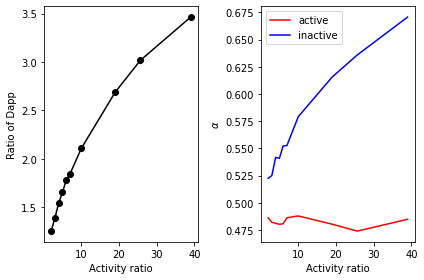

In [17]:
bigdf = bigdf.sort_values('activity_ratio')
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(bigdf['activity_ratio'], bigdf['Dapp_A'] / bigdf['Dapp_B'], 'k-o')
ax1.set_xlabel('Activity ratio')
ax1.set_ylabel('Ratio of Dapp')
ax2.plot(bigdf['activity_ratio'], bigdf['alpha_A'], color='red', label='active')
ax2.plot(bigdf['activity_ratio'], bigdf['alpha_B'], color='blue', label='inactive')
ax2.legend()
ax2.set_xlabel('Activity ratio')
ax2.set_ylabel(r'$\alpha$')
fig.tight_layout()

1.0678779078488008e+00
5.065902454421098e-01
Predicted activity ratio: 2.1079717137404526


Text(0, 0.5, 'Monomer MSD')

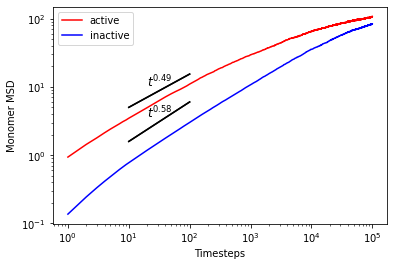

In [9]:
fig, ax = plt.subplots()
ax.loglog(df['Time'].values[1:], df['active_MSD'].values[1:], color='red', label='active')
ax.plot(df['Time'].values[1:], df['inactive_MSD'].values[1:], color='blue', label='inactive')
times = df['Time'].values
#active
res1 = scipy.stats.linregress(np.log10(times[(times > 10) & (times < 200)]), 
                            np.log10(df['active_MSD'][(times > 10) & (times < 200)]))
m1 = res1.slope
b1 = res1.intercept
corner = draw_power_law_triangle(m1, [1, 0.7], 1.0, 'up', hypotenuse_only=True)
plt.text(20, 10, f'$t^{{{m1:.2f}}}$', fontsize=12)
print(np.exp(b1))
#intercept is log(D_app)
#inactive
res2 = scipy.stats.linregress(np.log10(times[(times > 10) & (times < 200)]), 
                            np.log10(df['inactive_MSD'][(times > 10) & (times < 200)]))
m2 = res2.slope
b2 = res2.intercept
print(np.exp(b2))
act_ratio = np.exp(b1 - b2)
print(f'Predicted activity ratio: {act_ratio}')
plt.text(20, 3.5, f'$t^{{{m2:.2f}}}$', fontsize=12)
corner = draw_power_law_triangle(m2, [1, 0.2], 1.0, 'down', hypotenuse_only=True)
plt.legend()
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Monomer MSD')
#plt.savefig('plots/ens_ave_msd_every10_blobel2021_comp5.974x.png')

In [51]:
print(1.0664960212965036e+00 / 6.000461286408784e-01)

1.7773567237441354


In [46]:
act_ratio = 5.974
Ddiff = (act_ratio - 1) / (act_ratio + 1)
print(1.0 + Ddiff)
print(1.0 - Ddiff)

1.7132205334098078
0.28677946659019216


In [76]:
monomer_density = 0.224 * 2
print(monomer_density)
r_C = (3 * 1000 / (4 * 3.141592 * monomer_density)) ** (1/3)
print(r_C)
phi = 1000 * (0.5)**3 / r_C**3
phi

0.448
8.107329467812114


0.2345722026666668

In [7]:
def plot_MSD_ave(datadir, every_other=100):
    starting_pos = load_hdf5_file(Path(datadir)/"starting_conformation_0.h5")['pos']
    #check that only members of force group 1 moved
    avg_msd = None
    
    data = list_URIs(datadir)
    dxs = []
    prev_pos = starting_pos
    for conformation in data[::every_other]:
        pos = load_URI(conformation)['pos']
        dx_squared = np.sum((pos - starting_pos)**2, axis=-1)
        dxs.append(dx_squared)

    dxs = np.array(dxs)
    times = np.arange(1, len(data) + 1, every_other)
    D = 0.25 * np.ones(100)
    D[10:30] = 1.75
    D[50:80] = 1.75
    plt.plot(times, np.mean(dxs[:, D==D.min()], axis=1), label='cold')
    plt.plot(times, np.mean(dxs[:, D==D.max()], axis=1), label='hot')
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Timesteps')
    plt.ylabel('MSD')
    plt.savefig('plots/step7x_long_run_msd.pdf')

In [14]:
def extract_hot_cold(simdir, D, every_other=10):
    X = []
    starting_pos = load_hdf5_file(Path(simdir)/"starting_conformation_0.h5")['pos']
    X.append(starting_pos)
    data = list_URIs(simdir)
    for conformation in data[::every_other]:
        pos = load_URI(conformation)['pos']
        X.append(pos)
    X = np.array(X)
    Xcold = X[:, D==D.min(), :]
    Xhot = X[:, D==D.max(), :]
    return Xcold, Xhot

In [13]:
D = 0.25 * np.ones(100)
D[10:30] = 1.75
D[50:80] = 1.75
Xcold, Xhot = extract_hot_cold('/home/dkannan/simulations/step_7x/long_runs/run0')
Xcold.shape

(10001, 50, 3)

In [16]:
D = 1.9 * np.ones(100)
D[20:40] = 0.1
D[60:80] = 0.1
Xcold, Xhot = extract_hot_cold('/home/dkannan/simulations/corr_step19x/ensemble10000_100/run0', D, 
                              every_other=1)
Xcold.shape

(10001, 40, 3)

In [20]:
@jit(nopython=True)
def get_bead_msd_time_ave(Xhot, Xcold):
    """Return mean of hot monomer MSDs and cold monomer MSDs."""
    num_t, num_hot, d = Xhot.shape
    hot_msd = np.zeros((num_t - 1,))
    cold_msd = np.zeros((num_t - 1,))
    count = np.zeros((num_t - 1,))
    for i in range(num_t - 1):
        for j in range(i, num_t - 1):
            diff = Xhot[j] - Xhot[i]
            hot_msd[j-i] += np.mean(np.sum(diff * diff, axis=-1))
            diff = Xcold[j] - Xcold[i]
            cold_msd[j-i] += np.mean(np.sum(diff * diff, axis=-1))
            count[j-i] += 1
    return hot_msd, cold_msd, count

@jit(nopython=True)
def get_bead_msd(Xhot, Xcold):
    """Return mean of hot monomer MSDs and cold monomer MSDs."""
    num_t, num_hot, d = Xhot.shape
    hot_msd = np.zeros((num_t - 1,))
    cold_msd = np.zeros((num_t - 1,))
    for j in range(1, num_t):
        diff = Xhot[j] - Xhot[0]
        hot_msd[j-1] += np.mean(np.sum(diff * diff, axis=-1))
        diff = Xcold[j] - Xcold[0]
        cold_msd[j-1] += np.mean(np.sum(diff * diff, axis=-1))
    return hot_msd, cold_msd

<IPython.core.display.Javascript object>


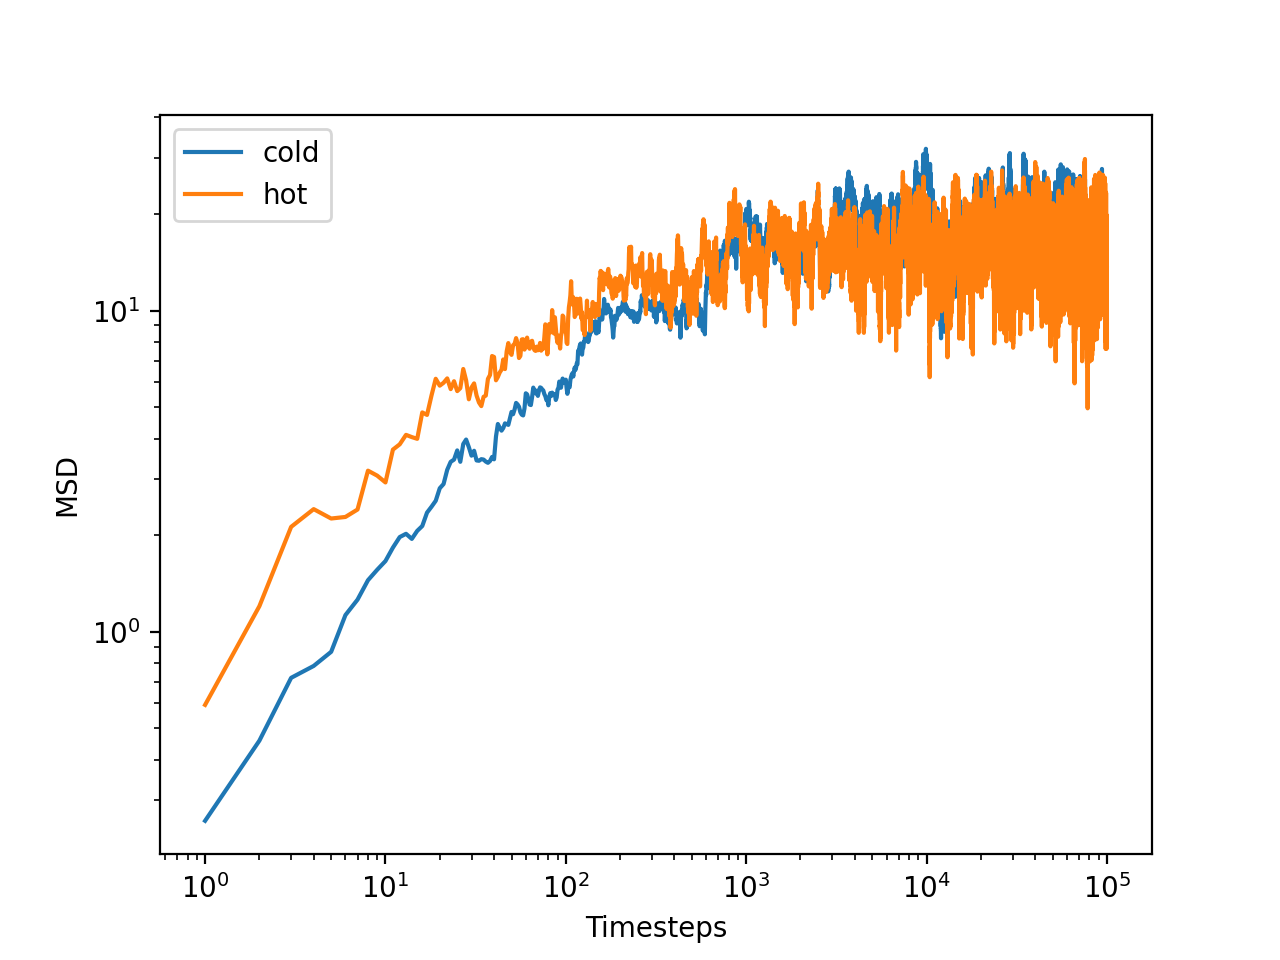

FileNotFoundError: [Errno 2] No such file or directory: 'plots/step7x_long_run_msd.pdf'

In [10]:
plot_MSD_ave('/home/dkannan/simulations/step_7x/long_runs/run0', every_other=1)

In [18]:
hot_msd, cold_msd, count = get_bead_msd(Xhot, Xcold)


0.7461112085459513
0.2561084016710567


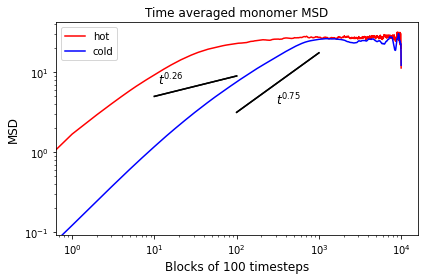

In [20]:
data = list_URIs('/home/dkannan/simulations/corr_step19x/ensemble10000_100/run0')
hot_msd_ave = hot_msd / count
cold_msd_ave = cold_msd / count
fig, ax = plt.subplots()
times = np.arange(0, len(data), 1)
ax.plot(times, hot_msd_ave, 'r-', label='hot')
ax.plot(times, cold_msd_ave, 'b-', label='cold')
m1 = scipy.stats.linregress(np.log10(times[(times > 10) & (times < 200)]), 
                            np.log10(cold_msd_ave[(times > 10) & (times < 200)]))[0]
print(m1)
plt.text(300, 4.0, f'$t^{{{m1:.2f}}}$', fontsize=12)
corner = draw_power_law_triangle(m1, [2, 0.5], 1.0, 'down', hypotenuse_only=True)
m2 = scipy.stats.linregress(np.log10(times[(times > 10) & (times < 200)]), 
                            np.log10(hot_msd_ave[(times > 10) & (times < 200)]))[0]
corner = draw_power_law_triangle(m2, [1, 0.7], 1.0, 'up', hypotenuse_only=True)
plt.text(11, 7, f'$t^{{{m2:.2f}}}$', fontsize=12)
print(m2)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Blocks of 100 timesteps', fontsize=12)
plt.ylabel('MSD', fontsize=12)
plt.title('Time averaged monomer MSD')
fig.tight_layout()
plt.savefig('plots/corr_step19x_run0_monomer_msd.pdf')

In [ ]:
#What is the Rouse time for this system?
from simtk import unit
rouse_time = 